# Credite Default Prediction

## Libraries & scripts

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from catboost import CatBoostClassifier, cv, Pool
from hyperopt import hp
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

plt.rcParams['figure.figsize'] = [16, 12]

## Data loading

In [9]:
train_df = pd.read_csv('course_project_train.csv')
test_df = pd.read_csv('course_project_test.csv')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [10]:
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


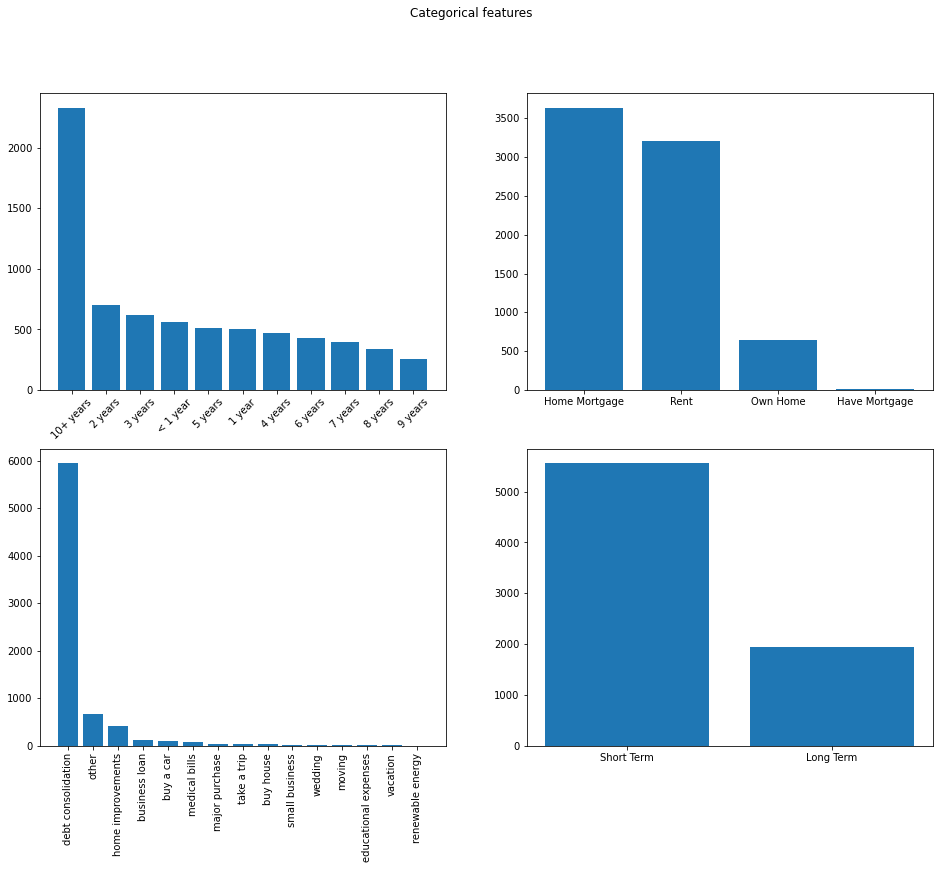

In [11]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

ax1.bar(train_df['Years in current job'].value_counts().index, train_df['Years in current job'].value_counts().values)
ax2.bar(train_df['Home Ownership'].value_counts().index, train_df['Home Ownership'].value_counts().values)
ax3.bar(train_df['Purpose'].value_counts().index, train_df['Purpose'].value_counts().values)
ax4.bar(train_df['Term'].value_counts().index, train_df['Term'].value_counts().values)

fig.suptitle('Categorical features')
ax1.xaxis.set_tick_params(rotation=45)
ax3.xaxis.set_tick_params(rotation=90)


In [12]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

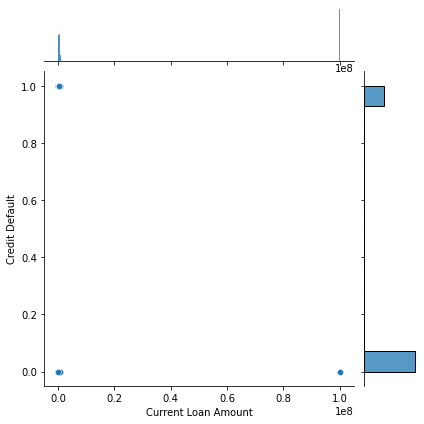

In [13]:
seaborn.jointplot(x='Current Loan Amount', y='Credit Default', 
              data=train_df, kind='scatter');

#### На графике видно, что все, у кого была большая задолжность - погасили кредит. 
#### То есть это значение ошибочное. Попробуем заменить его нулем, и проверим на валидации.

In [14]:
train_mod = train_df.copy()
train_mod.loc[train_mod['Current Loan Amount'] == 99999999, 'Current Loan Amount'] = 0

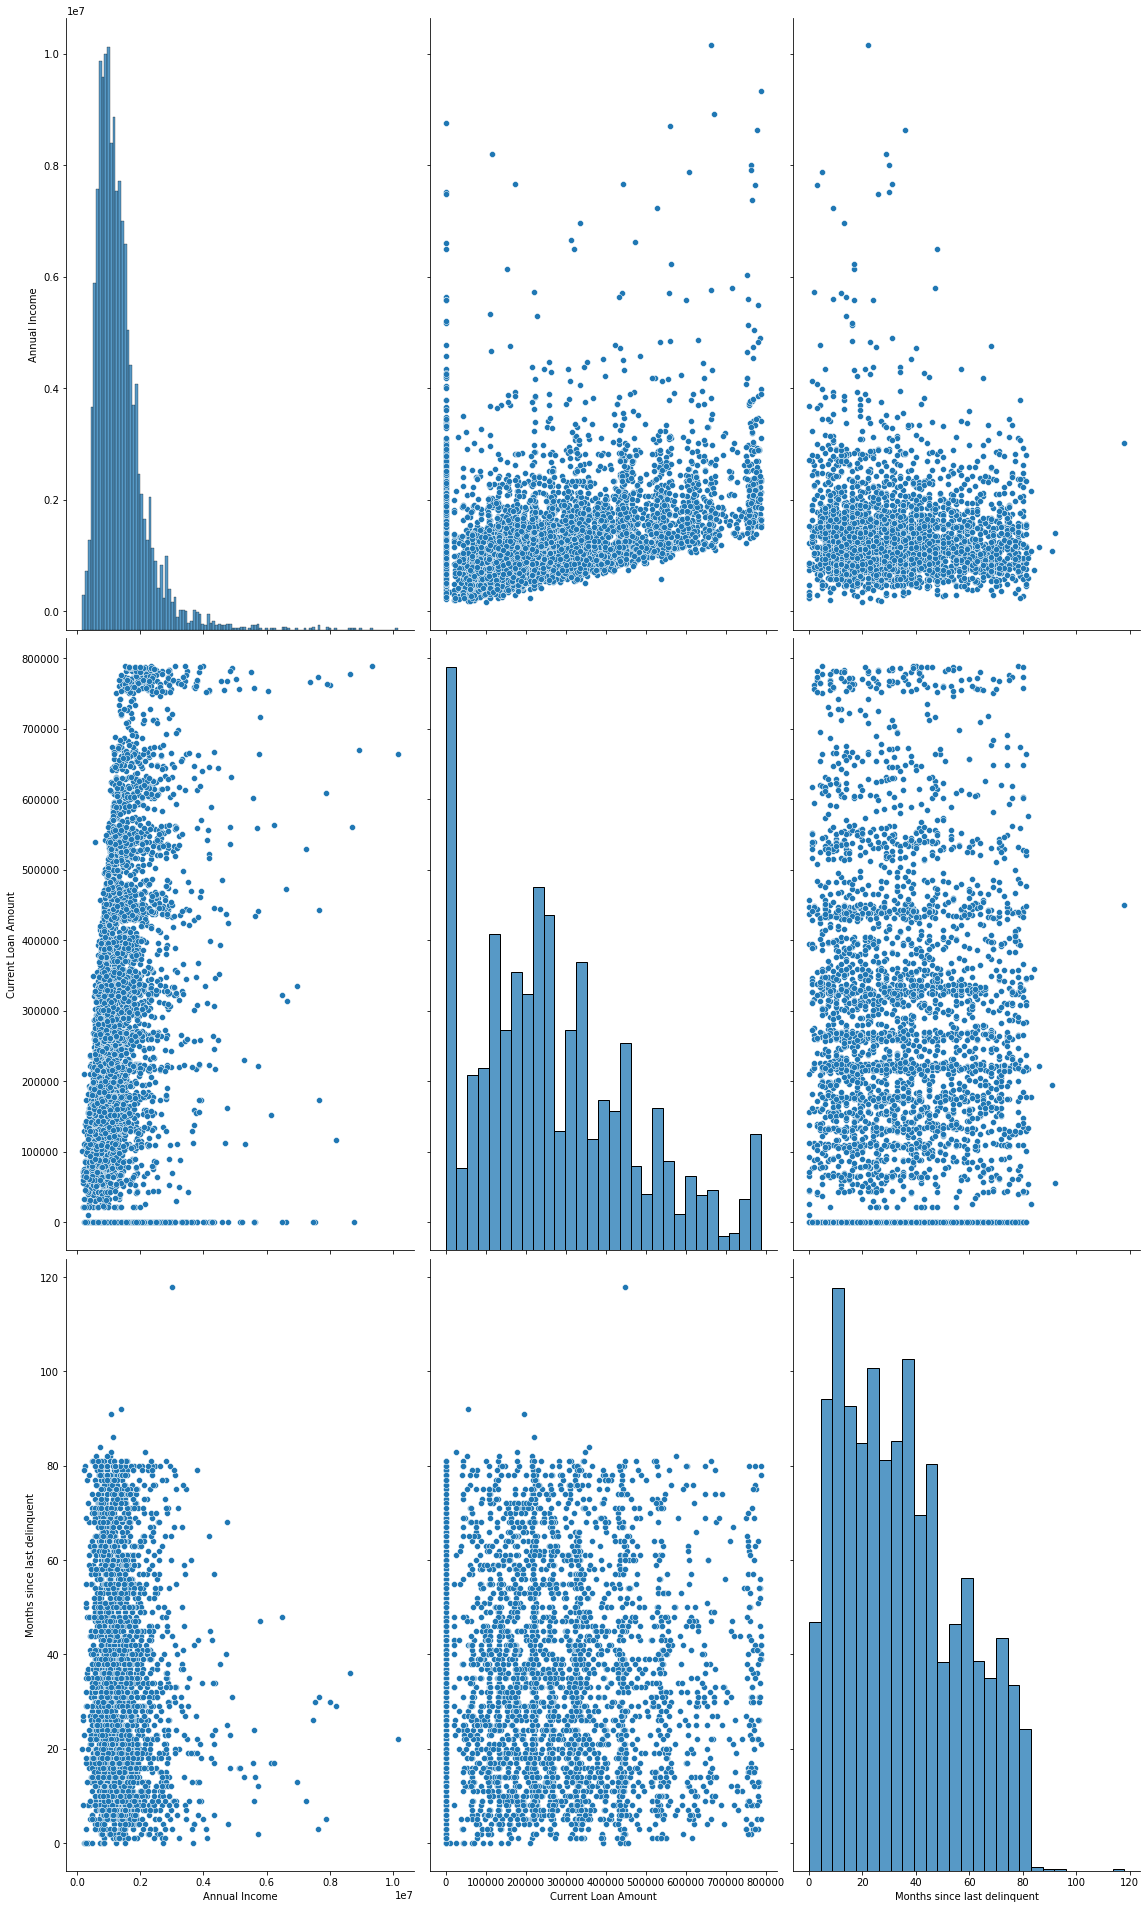

In [15]:
seaborn.pairplot(train_mod[['Annual Income', 'Current Loan Amount', 'Months since last delinquent']], height=9, aspect=0.6)

#### Видим, что все категориальные фичи, кроме продолжительности работы, в обоих датасетах не имеют пустых значений. Тех, у кого в столбце продолжительности работы пустое значение, принимаем за безработных и вставляем ноль.

#### Как будем обрабатывать фичи:

#### Закодируем продолжительность вручную, при этом сохранится численная зависимость продолжительности (10 лет > 9). Немного сдвинутся числа, но это не так критично. LabelEncoder не подойдет, потому что он сортирует перед кодированием, и 10+ лет будет сразу после 1 года.
#### Пустые значения в колонке просрочки будем считать отсутсвием просрочки и заполним нулем.
#### Так как годовой доход не кореллирует со временем последнего погашения и просрочкой, заполним пропуски средним значением.
#### Отсутствие информации о кредитном рейтинге и банкротстве примем за нулевой рейтинг и отсутсвие банкротства.

#### Посмотрим ещё сбалансированность классов

In [16]:
train_df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

#### Чистим фичи

In [17]:
test_df['Years in current job'].value_counts()

#В тесте новых вариантов нет, соответственно энкодер не будет выдавать ошибку


10+ years    810
3 years      228
2 years      212
< 1 year     207
5 years      169
1 year       153
4 years      152
7 years      140
6 years      137
8 years      107
9 years       99
Name: Years in current job, dtype: int64

In [18]:
train_mod['Years in current job'] = train_mod['Years in current job'].fillna('0').map({'0': 0, '< 1 year': 1, '1 year': 2, '2 years': 3,
                                                                                       '3 years': 4, '4 years': 5, '5 years': 6, '6 years': 7, 
                                                                                       '7 years': 8, '8 years': 9, '9 years': 10, '10+ years': 11})
train_mod.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,0,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,0.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,11,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,9,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,0.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,7,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,9,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [19]:
train_mod.loc[:, ['Months since last delinquent', 'Bankruptcies', 'Credit Score']] = train_mod.loc[:, ['Months since last delinquent', 
                                                                                                       'Bankruptcies', 'Credit Score']].fillna(value=0)
train_mod['Annual Income'].fillna(value=train_mod['Annual Income'].mean(), inplace=True)
train_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   int64  
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

#### Будем использовать CatBoost, потому что:

#### - у нас много категориальных фич и интересно посмотреть, как он сработает
#### - ансабли "слабых" моделей работают на практике лучше любых других классических моделей на линейно неразделимых задачах

In [20]:
categorical_features_indices = np.where((train_mod.dtypes == object))[0]
categorical_features_names = train_mod.iloc[:, list(np.where(train_mod.dtypes == object)[0])].columns

In [22]:
X_train, X_valid, y_train, y_valid = train_test_split(train_mod.drop('Credit Default', axis=1), train_mod['Credit Default'], train_size=0.75, random_state=42)

In [23]:
class ClassifierObjective(object):
    def __init__(self, trainset, validset, const_params):
        self.train_dataset = trainset
        self.valid_dataset = validset
        self._const_params = const_params.copy()
        
    def _to_catboost_params(self, hyper_params):
        return {'iterations': int(hyper_params['iterations']),
                'learning_rate': hyper_params['learning_rate'],
                'depth': hyper_params['depth'],
                'l2_leaf_reg': hyper_params['l2_leaf_reg']}
    
    def __call__(self, hyper_params):
        params = self._to_catboost_params(hyper_params)
        params.update(self._const_params)
        
        print('\nEvaluating with params={}'.format(params))
        
        clf = CatBoostClassifier(**params)
        clf.fit(self.train_dataset, eval_set=self.valid_dataset, use_best_model=True)
        preds = clf.predict(self.valid_dataset)
        
        score = f1_score(self.valid_dataset.get_label(), preds)
        print('\nevaluated score={}'.format(score))
        
        return {'loss': 1-score, 'status': STATUS_OK}

In [24]:
def find_best_hyper_params(trainset, validset, const_params, max_evals=100):    
    parameter_space = {'iterations': hp.randint('iterations', 1500),
                       'learning_rate': hp.uniform('learning_rate', 0.2, 1.0),
                       'depth': hp.randint('depth', 15),
                       'l2_leaf_reg': hp.uniform('l2_leaf_reg', 1, 10)}
    objective = ClassifierObjective(trainset, validset, const_params=const_params)
    trials = Trials()
    best = fmin(fn=objective, space=parameter_space, algo=tpe.suggest, max_evals=max_evals)
    return best

In [25]:
def train_best_model(X_tr, y_tr, X_val, y_val, X_all, y_all, const_params, cat_features, max_evals=100):
    trainset = Pool(X_tr, y_tr, cat_features=cat_features)
    validset = Pool(X_val, y_val, cat_features=cat_features)
    dataset = Pool(X_all, y_all, cat_features=cat_features)
    
    best = find_best_hyper_params(trainset, validset, const_params, max_evals=max_evals)
  
    hyper_params = best.copy()
    hyper_params.update(const_params)
    
    model = CatBoostClassifier(**hyper_params)
    model.fit(dataset, verbose=False)
    
    return model, hyper_params

In [26]:
w = train_df['Credit Default'].value_counts()[0] / train_df['Credit Default'].value_counts()[1]
const_params = dict({'task_type': 'CPU',
                    'loss_function': 'Logloss',
                    'eval_metric': 'F1', 
                    'custom_metric': ['F1'],
                    'class_weights': [1, w],
                    'verbose': 200})

In [27]:
model, params = train_best_model(X_train, y_train, X_valid, y_valid,
                                 train_mod.drop('Credit Default', axis=1), train_mod['Credit Default'],
                                 const_params, categorical_features_indices, max_evals=50)
print('best params are {}'.format(params))

                                                      
Evaluating with params={'iterations': 1045, 'learning_rate': 0.9383298428629476, 'depth': 10, 'l2_leaf_reg': 1.6221939306427786, 'task_type': 'CPU', 'loss_function': 'Logloss', 'eval_metric': 'F1', 'custom_metric': ['F1'], 'class_weights': [1, 2.549455750118315], 'verbose': 200}
  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]0:	learn: 0.6466471	test: 0.6151285	best: 0.6151285 (0)	total: 191ms	remaining: 3m 19s
200:	learn: 1.0000000	test: 0.5661882	best: 0.6536200 (1)	total: 9.17s	remaining: 38.5s
400:	learn: 1.0000000	test: 0.5617758	best: 0.6536200 (1)	total: 18.4s	remaining: 29.5s
600:	learn: 1.0000000	test: 0.5649749	best: 0.6536200 (1)	total: 27.6s	remaining: 20.4s
800:	learn: 1.0000000	test: 0.5615303	best: 0.6536200 (1)	total: 36.8s	remaining: 11.2s
1000:	learn: 1.0000000	test: 0.5615303	best: 0.6536200 (1)	total: 46s	remaining: 2.02s
1044:	learn: 1.0000000	test: 0.5615303	best: 0.6536200 (1)	total: 48.1s	remaining: 0u

### Оцениваем важность фич

<BarContainer object of 16 artists>

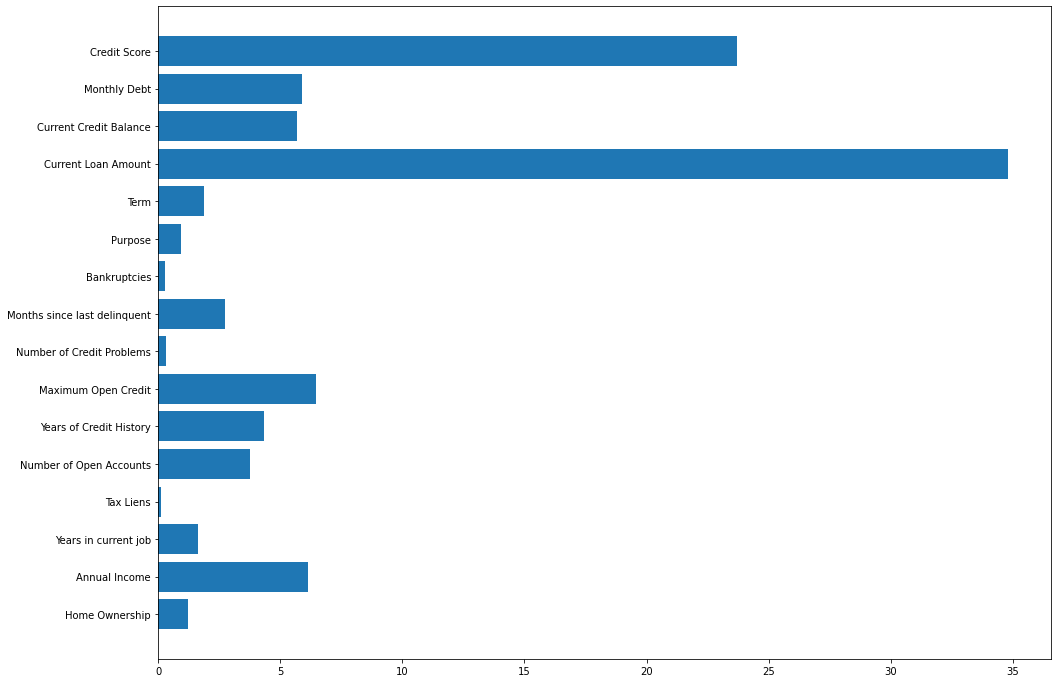

In [28]:
plt.barh(train_mod.drop('Credit Default', axis=1).columns, model.get_feature_importance())

In [29]:
preds = model.predict(train_mod.drop('Credit Default', axis=1))
f1_sc = f1_score(train_mod['Credit Default'], preds)
p_score = precision_score(train_mod['Credit Default'], preds)
r_score = recall_score(train_mod['Credit Default'], preds)
print('F1-score: {:.3}\nWith precision = {:.3} and recall = {:.3}'.format(f1_sc, p_score, r_score))

F1-score: 0.736
With precision = 0.654 and recall = 0.843


#### Требованиям задания решение удовлетворяет, поэтому проделаем чистку тестового набора данных и получим предсказания на нём

In [30]:
test_mod = test_df.copy()
test_mod.loc[test_mod['Current Loan Amount'] == 99999999, 'Current Loan Amount'] = 0
test_mod['Years in current job'] = test_mod['Years in current job'].fillna('0').map({'0': 0, '< 1 year': 1, '1 year': 2, '2 years': 3,
                                                                                     '3 years': 4, '4 years': 5, '5 years': 6, '6 years': 7, 
                                                                                     '7 years': 8, '8 years': 9, '9 years': 10, '10+ years': 11})
test_mod.loc[:, ['Months since last delinquent', 'Bankruptcies', 'Credit Score']] = test_mod.loc[:, ['Months since last delinquent', 
                                                                                                     'Bankruptcies', 'Credit Score']].fillna(value=0)
test_mod['Annual Income'].fillna(value=train_mod['Annual Income'].mean(), inplace=True)
test_mod.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 2500 non-null   float64
 2   Years in current job          2500 non-null   int64  
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  2500 non-null   float64
 9   Bankruptcies                  2500 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

In [31]:
final_preds = model.predict(test_mod)

predicted_df = pd.DataFrame(final_preds, columns=['Credit Default'])
predicted_df.to_csv('predicted_defaults.csv', index_label='id')

In [32]:
predicted_df.head()

,Credit Default
0,1
1,1
2,1
3,0
4,0


#### Сохраняем модель:

In [34]:
model.save_model('catboost_info/model.py', format='python', pool=train_mod.drop('Credit Default', axis=1))